# Setting Up Your Own Mindcontrol Instance

## Installing Mindcontrol

1. Install meteor

    ```bash
    curl https://install.meteor.com/ | sh
    ```

2. Clone mindcontrol

    ```bash
    git clone https://github.com/akeshavan/mindcontrol.git
    ```

3. Start the server

    ```bash
    cd mindcontrol
    meteor
    ```
    
    Leave this running in your terminal window.

4. Navigate to http://localhost:3000 in your chrome browser.
You should see the default entries loaded into the mindcontrol database. It should look like:

    ![](images/mindcontrol_install_init.png)




Here we see the "Exams" and "Freesurfer" modules. We are going to add a new module called "Test". First, we need to prepare our data

## Preparing and Serving Data

### Data organization

Make sure your data has a consistent organization structure.  Your base directory should look like:
    
    /base/directory
             |___ sub-01
                   |___ anat
                         |___ sub-01_T1w.nii.gz
             |___ sub-02
                   |___ anat
                         |___ sub-01_T1w.nii.gz
             |___ sub-03
                   |___ anat
                         |___ sub-01_T1w.nii.gz
    

This is the BIDS data organization, and you can find example at https://github.com/INCF/BIDS-examples. Pay close attention to you **`/base/directory`** -- this is where we will start a static server

### Starting a static server

In your **`/base/directory`**, create a file called **`start_static_server.py`**. Copy/paste the following into the file:

```python
#!/usr/bin/env python
import http.server
import os

class MyHTTPRequestHandler(http.server.SimpleHTTPRequestHandler):
    def end_headers(self):
        self.send_header("Access-Control-Allow-Origin", "*")
        http.server.SimpleHTTPRequestHandler.end_headers(self)

if __name__ == '__main__':
        http.server.test(HandlerClass=MyHTTPRequestHandler, port=3002)
```

`cd` to **`/base/directory`** and run the static server:

```bash
python start_static_server.py
```

To test that it works, in your browser navigate to http://localhost:3002. You should see your directory structure. Keep this running in a terminal window.

### Loading entries to the Mongo Database

In your **`/base/directory`**, create a file called **`load_test_entries.py`**. Copy/paste the following into the file:


```python
#!/usr/bin/env python
from glob import glob
import numpy as np

def get_collection(port=3001):
    from pymongo import MongoClient
    client = MongoClient("localhost", port)
    db =  client.meteor
    collection = db.subjects
    return collection, client

coll, cli = get_collection()
files = glob("sub*/anat/sub*_T1w.nii.gz")

for f in files:
    entry = {"entry_type":"test", # this is what we use to filter items into different tables in the UI. Instead of test, you can give it a meaningful name, like "raw_data" or "segmentation_file"
             "metrics":{"GMV": np.random.rand()*100, #these are random numbers, but you could load whatever you want here
             "WMV": np.random.rand()*100}}
    Sid = f.split('/')[0] #getting subject ID from the filename
    entry["subject_id"] = Sid
    entry["name"] = Sid
    entry["check_masks"] = [f] #list of paths to files relative to /base/directory
    coll.insert_one(entry) #finally, insert an entry to the mongo database

```

Run the python file to load data:
```bash
cd /base/directory
python load_test_entries.py
```

## Adding a New Module to Mindcontrol
Modules are groupings of similar data that can be used to filter and organize subjects for editing. For example, all data that has been processed by FreeSurfer will appear in the FreeSurfer module. You can find all modules at the top left of the Mindcontrol home window ::

![](images/mindcontrol_install_init_annot.png)

Each module is defined in the `mindcontrol/private/generator.json` file. We will focus only on the the `"modules"` key/value pair in this file. (The example below is commented, but the actual **JSON file does not support commenting**)

```javascript

{
  "modules": [
  {"name": "Exams", // Title of the table
    "entry_type": "demographic", // database entries to display in the table
  "fields": [ //list of dictionaries that describe each column of the table in order
    {"function_name": "get_filter_field", // describes what happens when an entry is clicked. In this case, it is filtered
      "id": "msid", // the name of the MongoDB field to display (in this case, its the MRI Subject ID (msid)
      "name": "msid" // column name to display
    },
   ... // more dictionaries follow
  ],
  "graph_type":"datehist", // type of graph to display (options: datehist or histogram)
  "showgraph": true}, //whether or not to show the graph (it can be collapsed if set to false)
    {
      "name": "Freesurfer",
      "entry_type": "freesurfer",
      "fields": [
        {
          "function_name": "get_filter_field",
          "id": "subject_id", //in this mindcontrol instance, the subject id is a combo of the subject_id & exam id since this value must be unique
          "name": "Exam ID"
        },
        {
          "function_name": "get_qc_viewer", // when the Freesurfer ID is clicked, show the QC viewer
          "id": "name", // the Mongo database should have a "name" entry 
          "name": "Freesurfer ID"
        },
        {
          "function_name": "get_qc_filter_field", // when a QC tag is clicked, filter by the QC status
          "id": "quality_check.QC",
          "name": "QC"
        },
        ...
        {
          "function_name": null, // do nothing for this column field
          "id": "quality_check.notes_QC",
          "name": "Notes"
        }
      ],
      "graph_type": "histogram", //the 1D hisgrogram of metrics
      "colormaps": { //this dictionary describes how to load the colormaps of the images
        "0":{"name": "Grayscale",
            "alpha": 1,
            "min": 0,
            "max": 255
        },
        "1": {
          "name": "custom.Freesurfer", //this is the Freesurfer colormap
          "alpha": 0.5
        }
      },
      "staticURL": "https://dl.dropboxusercontent.com/u/9020198/data/", //this is the base directory where images are served
      "usePeerJS": false //ignore this for now
    }
]}
```

Lets add a UI component for our "test" entries after the "freesurfer" entry:

```javascript
      "staticURL": "https://dl.dropboxusercontent.com/u/9020198/data/",
      "usePeerJS": false //ignore this for now
    }, // remember to add a comma here
    //copy/paste below:
{
      "name": "Test",
      "entry_type": "test",
      "fields": [
        {
          "function_name": "get_filter_field",
          "id": "subject_id",
          "name": "Exam ID"
        },
        {
          "function_name": "get_qc_viewer",
          "id": "name",
          "name": "View Image"
        },
        {
          "function_name": "get_qc_filter_field",
          "id": "quality_check.QC",
          "name": "QC"
        },
        {
          "function_name": "get_filter_field",
          "id": "checkedBy",
          "name": "checked by"
        },
        {
          "function_name": "get_filter_field",
          "id": "quality_check.user_assign",
          "name": "Assigned To"
        },
        {
          "function_name": null,
          "id": "quality_check.notes_QC",
          "name": "Notes"
        }
      ],
      "graph_type": "histogram",
      "staticURL": "http://localhost:3002/",
      "usePeerJS": false
    }
    //end copy/paste
]}

```

Note how we've set the staticURL field to the port of our static server:

```javascript
{
"staticURL": "http://localhost:3002/"
}
```
If your data is hosted on Dropbox or S3, change this URL. Next, 

```bash
cd mindcontrol/imports/python_generate
```

and run:

```bash
python generate_mindcontrol.py
```

Navigate to localhost:3000 once again, and see how a new module (named Test) has been added. Click on an entry in the "View Image" column to load the QC viewer.

![](images/mindcontrol_with_test_module.png)

Click on an entry in the View Image column, and you should see the QC viewer load. Remember to sign in before annotating!

![](images/signin_page.png)

Shift+click to annotate a point, and hit "Save"

![](images/point_annot.png)

Next we will grab the x,y,z coordinates of this annotation and plot it

In [1]:
# Use this function to get access to the mindcontrol mongo database entries
def get_collection(port=3001):
    from pymongo import MongoClient
    client = MongoClient("localhost", port)
    db =  client.meteor
    collection = db.subjects
    return collection, client

In [2]:
coll, cli = get_collection()

In [3]:
annot_entry = coll.find_one({"subject_id":"sub-01"})
annot_entry

{'_id': ObjectId('58e3e3b9d09d334fd518110d'),
 'check_masks': ['sub-01/anat/sub-01_T1w.nii.gz'],
 'checkedAt': datetime.datetime(2017, 4, 4, 18, 35, 26, 706000),
 'checkedBy': 'anisha',
 'contours': [],
 'entry_type': 'test',
 'loggedPoints': [{'checkedBy': 'anisha',
   'matrix_coor': {'x': 122.12844036697248, 'y': 49.467297993876976, 'z': 101},
   'note': 'test',
   'uuid': '08387f41-a2e7-c6d3-a1db-d8a4f3c76ab4',
   'world_coor': {'x': -6.251544525553783,
    'y': 51.88812322234088,
    'z': -17.075543789832125}}],
 'metrics': {'GMV': 95.69133269312357, 'WMV': 78.69580030146265},
 'name': 'sub-01',
 'painters': [],
 'quality_check': {'QC': '3', 'notes_QC': ''},
 'subject_id': 'sub-01'}

our world coordinates are in 

In [4]:
annot_entry["loggedPoints"][0]["world_coor"]

{'x': -6.251544525553783, 'y': 51.88812322234088, 'z': -17.075543789832125}

Plot the same annotation in Python using nilearn

In [5]:
from nilearn.plotting import plot_anat
%pylab inline

Populating the interactive namespace from numpy and matplotlib


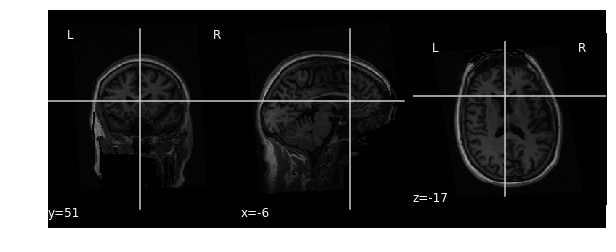

In [6]:
world_coords = [annot_entry["loggedPoints"][0]["world_coor"]["x"], 
                annot_entry["loggedPoints"][0]["world_coor"]["y"],
                annot_entry["loggedPoints"][0]["world_coor"]["z"]]
fig, ax = subplots(1,1,figsize=(10,4))
plot_anat("mindcontrol_base_dir/sub-01/anat/sub-01_T1w.nii.gz", 
          cut_coords=world_coords, axes=ax)

You can also convert the world-coordinates to matrix indices using nibabel

In [9]:
import nibabel as nib
img = nib.load("mindcontrol_base_dir/sub-01/anat/sub-01_T1w.nii.gz")
data, aff = img.get_data(), img.affine

In [14]:
np.round(np.linalg.inv(aff) @ np.asarray(world_coords + [1]))[:3]

array([ 123.,  104.,  149.])

The intensity value at this point is:

In [15]:
data[124, 104, 149]

588.0

**Reccomendation:** Make sure that image affine does not have rotations for voxel painting to work. Clicking on this button at the top right: ![](images/world_icon.png) or ![](images/index_icon.png) should not change the image orientation. One way to ensure this is the case is to **rigidly register your image to MNI space**

## Conclusion

This tutorial explained the basics of configuring Mindcontrol for your own data, and then extracting annotations from the mindcontrol database. For more information, see other tutorials:

* [Using the MongoDB Shell](https://github.com/akeshavan/mindcontrol_docs/blob/master/Mindcontrol_Mongo_shell_explained.ipynb)
* [Mindcontrol & Pipeline for Freesurfer Editing](https://github.com/akeshavan/mindcontrol_docs/blob/master/MindPrepFS.ipynb)